In [1]:
import os
import pickle
import pathlib

import matplotlib.pyplot as plt
import glob
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from tensorflow.python.platform import gfile

import input_data

import IPython.display as ipd
from scipy.io import wavfile

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
sns.set()
sns.set_palette("bright")
# sns.set(font_scale=1)

# zero-shot and few-shot analysis

In [4]:
data_dir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/"
os.chdir("/home/mark/tinyspeech_harvard/train_100_augment/")
with open("wordlist.txt", "r") as fh:
    commands = fh.read().splitlines()
with open("files.txt", "r") as fh:
    files = fh.read().splitlines()    
    
ten_pct = int(0.1 * len(files))
train_split = ten_pct * 8 
val_split = train_split + ten_pct

train_files = files[:train_split]
val_files = files[train_split:val_split]
test_files = files[val_split:]

print(len(train_files), len(val_files), len(test_files))    
model_settings = input_data.prepare_model_settings(
        label_count=100,
        sample_rate=16000,
        clip_duration_ms=1000,
        window_size_ms=30,
        window_stride_ms=20,
        feature_bin_count=40,
        preprocess="micro",
    )
bg_datadir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/_background_noise_/"

a = input_data.AudioDataset(model_settings, commands, bg_datadir, [], unknown_percentage=0)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = a.init(AUTOTUNE, train_files, is_training=True)
val_ds = a.init(AUTOTUNE, val_files, is_training=False)
test_ds = a.init(AUTOTUNE, test_files, is_training=False)
batch_size = 64
train_ds = train_ds.shuffle(buffer_size=4000).batch(batch_size)
val_ds = val_ds.batch(batch_size)

160000 20000 20000


In [5]:
model = tf.keras.models.load_model("./hundredword_resnet_2k_selu.48-0.87")

penultimate = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer("dense_21").output)

In [ ]:
test_audio = []
test_labels = []

for ix,(audio, label) in enumerate(test_ds):
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())
    if ix % 6000 == 0:
        print(ix)
    #if ix > 8000:
    #    break

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

In [40]:
other_words = [w for w in os.listdir(data_dir) if w != "_background_noise_" and w not in commands]
other_words.sort()
print(len(other_words))
assert(len(set(other_words).intersection(commands))==0)

165


In [6]:
def to_embedding(file_path):
    spectrogram = a.file2spec(file_path, add_bg=False)
    spectrogram = spectrogram.numpy().reshape(1,49,40,1)
    embedding = penultimate.predict(spectrogram)
    return np.squeeze(embedding)

In [86]:
def to_embeddings_vectorized(file_paths):
    spectrograms = [a.file2spec(f, add_bg=False) for f in file_paths]
    spectrograms = [s.numpy().reshape(1,49,40,1) for s in spectrograms]
    spectrograms = np.concatenate(spectrograms)
    embeddings = penultimate.predict(spectrograms)
    return embeddings

In [8]:
candidate_word="appeared"
target = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_20522625.wav"

In [ ]:
candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
print(candidate_word, target)
NUM_SAMPLES=200
samples = np.random.choice(candidates, NUM_SAMPLES, replace=False)
samples = [s for s in samples if s != target]

distances_to_target=[]
target_embedding = to_embedding(target)
for ix,w in enumerate(samples):
    e = to_embedding(w)
    d = np.linalg.norm(target_embedding - e)
    distances_to_target.append(d)

values, bins, _ = plt.hist(distances_to_target,bins=50);    

# few-shot target words selected blindly

In [90]:
NUM_SAMPLES=200
THRESH = 0.9
NON_TARGET_WORDS = 5
FEW_SHOT = 5
candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
samples = np.random.choice(candidates, NUM_SAMPLES + FEW_SHOT, replace=False)

targets = samples[:FEW_SHOT]
additional_samples = samples[FEW_SHOT:]

target_embeddings = to_embeddings_vectorized(targets)
print(target_embeddings.shape)
# distances = [min_distance_to_embeddings(target_embeddings, f) for f in additional_samples]

# threshold = np.quantile(distances, THRESH)

# non_target_words = np.random.choice(other_words, NON_TARGET_WORDS + 1, replace=False)
# non_target_words = [w for w in non_target_words if w != candidate_word][:NON_TARGET_WORDS]


(5, 128)


In [91]:
additional_samples.shape

(200,)

In [93]:
es = to_embeddings_vectorized(additional_samples)

In [94]:
es.shape

(200, 128)

In [95]:
(es-target_embeddings).shape

ValueError: operands could not be broadcast together with shapes (200,128) (5,128) 

## broadcasting scratch for vectorizing few-shot embeddings

In [142]:
gs = np.random.rand(3,4) * 100 # 3 candidate embeddings of len 4
hs = np.random.rand(2,4) * 100 # 2-shot embedding vectors of len 4
gs = np.round(gs)
hs = np.round(hs)
print(gs)
print(hs)
print("--")

print(gs[:,np.newaxis,:].shape)
print("--")

# 3x2x4: 3 candidate embeddings - each of the 2-shot embedding vectors
# gs[0] - hs[0] is res[0][0] (len:4)
# gs[0] - hs[1] is res[0][1] (len:4)
res = gs[:,np.newaxis,:] - hs 
print("result")
print(res)
print(res.shape)
print("--")

print(gs[1] - hs[0])
print(gs[1] - hs[1])
print("--")

n = np.linalg.norm(res,axis=2)
print(n)
print(n.shape)
fst = np.linalg.norm(gs[1] - hs[0])
snd = np.linalg.norm(gs[1] - hs[1])
print(fst,snd)

print(np.amin(n,axis=1))

[[91. 26. 96. 76.]
 [41. 10. 90. 36.]
 [ 1. 44. 64. 75.]]
[[22. 12. 32.  2.]
 [69. 69.  2. 61.]]
--
(3, 1, 4)
--
result
[[[ 69.  14.  64.  74.]
  [ 22. -43.  94.  15.]]

 [[ 19.  -2.  58.  34.]
  [-28. -59.  88. -25.]]

 [[-21.  32.  32.  73.]
  [-68. -25.  62.  14.]]]
(3, 2, 4)
--
[19. -2. 58. 34.]
[-28. -59.  88. -25.]
--
[[120.53630159 106.74268125]
 [ 69.89277502 112.40106761]
 [ 88.41945487  96.37945839]]
(3, 2)
69.8927750200262 112.40106761058811
[106.74268125  69.89277502  88.41945487]


In [136]:
res[0][0]

array([-20.,  25., -27.,  14.])

small
get
building
named
group
south
same
war
look


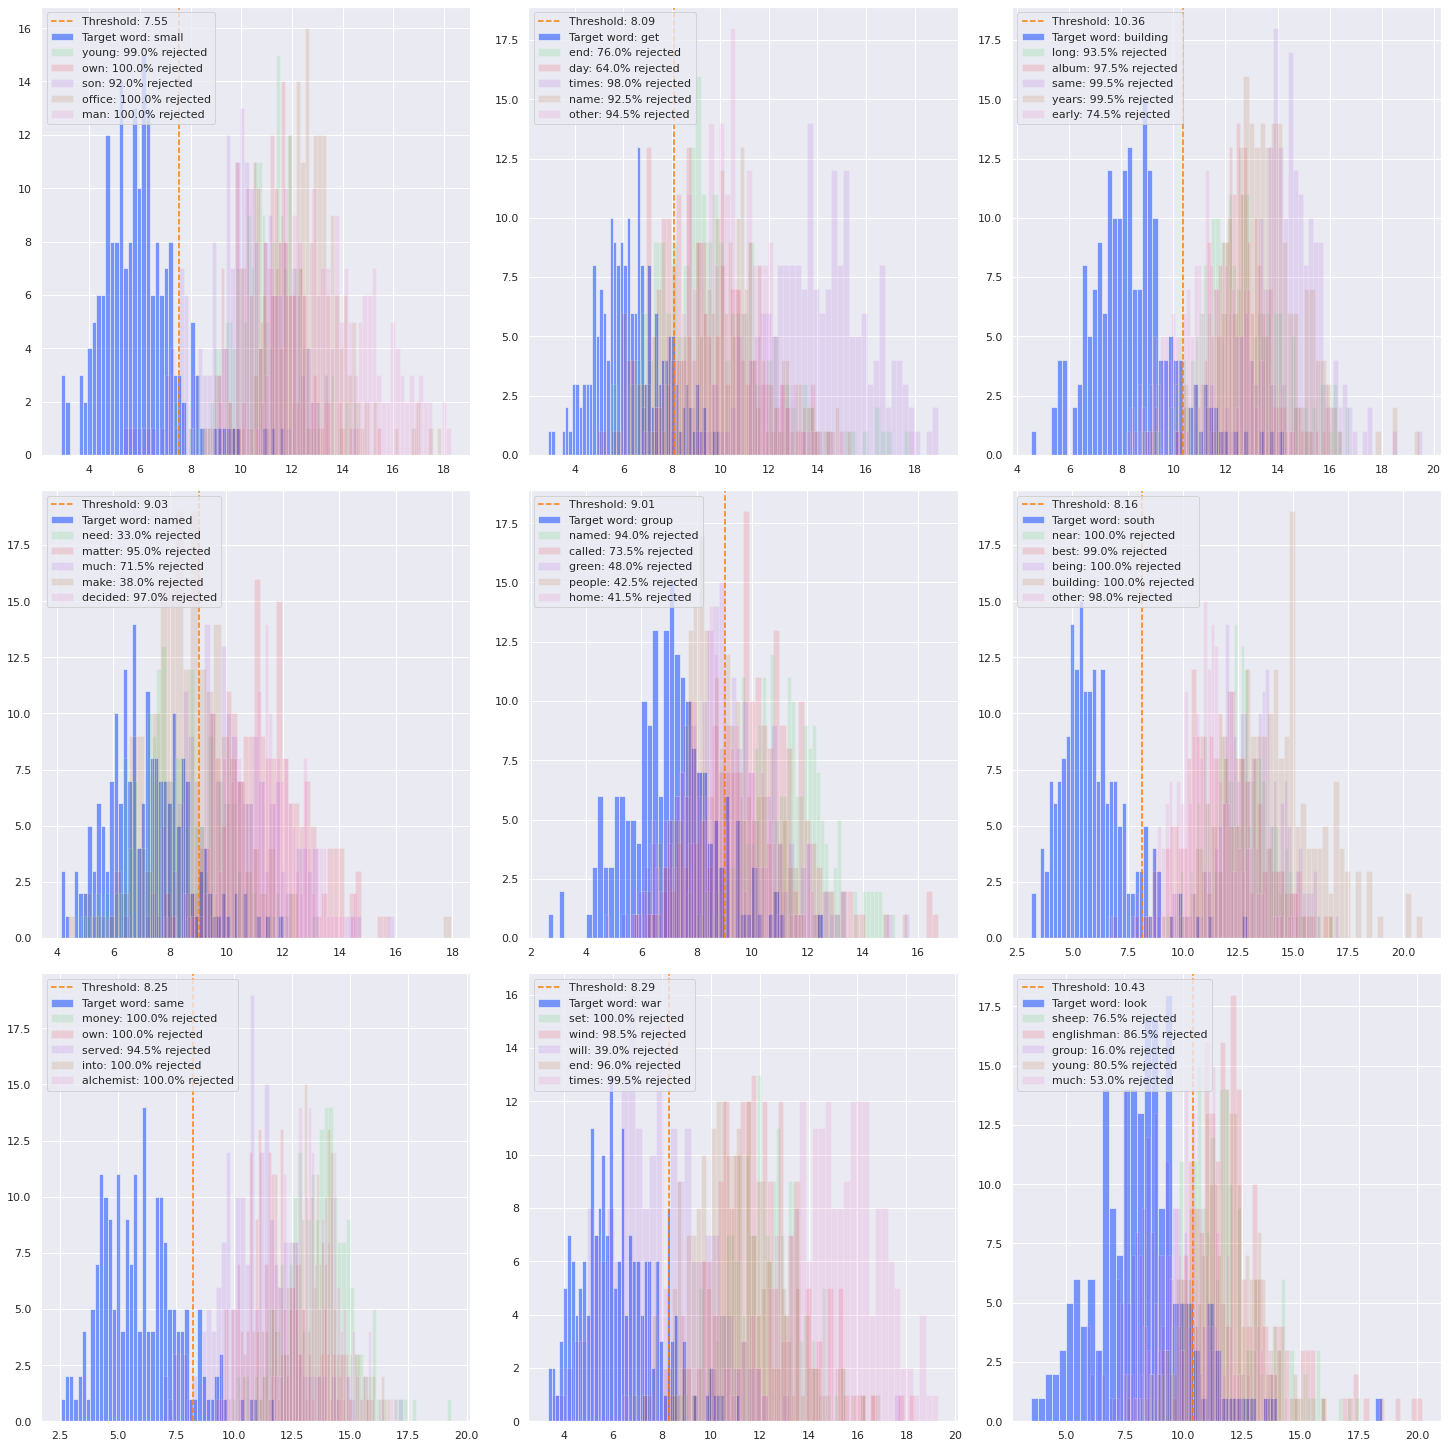

In [144]:
NUM_SAMPLES=200
THRESH = 0.9
NON_TARGET_WORDS = 5
FEW_SHOT = 5

NUM_WORDS =9
nrows,ncols = 3,3
fig,axes= plt.subplots(nrows=nrows,ncols=ncols,constrained_layout=True)
assert nrows * ncols == NUM_WORDS

def min_distance_to_embeddings(target_embeddings, file_paths):
    e = to_embedding(file_path)
    es = to_embeddings_vectorized(file_paths)
    distances = np.linalg.norm(target_embeddings - e, axis=1)
    return np.amin(distances)

def vectorized_min_distances_to_few_shot_embeddings(target_embeddings, file_paths):
    candidate_embeddings = to_embeddings_vectorized(file_paths)
    # n_candidate_embeddings x 1 x embedding_width
    candidate_embeddings = candidate_embeddings[:,np.newaxis,:]
    # n_candidate_embeddings x m_target_embeddings x embedding_width
    a_to_b = candidate_embeddings - target_embeddings

    # n_candidate_embeddings x m_target_embeddings
    distances = np.linalg.norm(a_to_b, axis=2)
    return np.amin(distances,axis=1)

candidate_words = np.random.choice(other_words, NUM_WORDS, replace=False)
for ix,candidate_word in enumerate(candidate_words):
    row = ix // nrows
    col = ix % ncols
    ax = axes[row][col]
    print(candidate_word)
    
    candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
    samples = np.random.choice(candidates, NUM_SAMPLES + FEW_SHOT, replace=False)

    targets = samples[:FEW_SHOT]
    additional_samples = samples[FEW_SHOT:]

    target_embeddings = to_embeddings_vectorized(targets) 
    #distances = [min_distance_to_embeddings(target_embeddings, f) for f in additional_samples]
    distances = vectorized_min_distances_to_few_shot_embeddings(target_embeddings, additional_samples)
    
    threshold = np.quantile(distances, THRESH)
    
    non_target_words = np.random.choice(other_words, NON_TARGET_WORDS + 1, replace=False)
    non_target_words = [w for w in non_target_words if w != candidate_word][:NON_TARGET_WORDS]
    
    # target distance distribution
    ax.hist(distances, bins=50, alpha=0.5, label=f"Target word: {candidate_word}", color=sns.color_palette("bright")[0]);
    # target threshold
    ax.axvline(x=threshold, label=f"Threshold: {threshold:.2f}", linestyle="--", color=sns.color_palette("bright")[1])
    
    for jx, w in enumerate(non_target_words):
        non_target_candidates = glob.glob(f"{data_dir}{w}/*.wav")
        non_target_samples = np.random.choice(non_target_candidates, NUM_SAMPLES, replace=False)
        non_target_distances = vectorized_min_distances_to_few_shot_embeddings(target_embeddings, non_target_samples)
        
        correct_rejected_pct = (non_target_distances[non_target_distances > threshold].shape[0] / NUM_SAMPLES) * 100
        
        ax.hist(non_target_distances, bins=50, alpha=0.125, label=f"{w}: {correct_rejected_pct:.1f}% rejected", color=sns.color_palette("bright")[jx + 2]);        
   
    ax.legend(loc='upper left');    
fig.set_size_inches(20,20);

# zero-shot, but first listening to each target keyword

In [132]:
NUM_WORDS =9
candidate_words = np.random.choice(other_words, NUM_WORDS, replace=False)
print(candidate_words)

['building' 'river' 'find' 'several' 'most' 'high' 'looking' 'around'
 'such']


In [133]:
candidate_targets = [None for _ in range(NUM_WORDS)]

In [255]:
ix = 7
candidates = glob.glob(f"{data_dir}{candidate_words[ix]}/*.wav")
target = np.random.choice(candidates)
print(target)
ipd.Audio(target, autoplay=True)

/home/mark/tinyspeech_harvard/frequent_words/en/clips/around/common_voice_en_18355828.wav


In [256]:
candidate_targets[ix] = target
candidate_targets

['/home/mark/tinyspeech_harvard/frequent_words/en/clips/building/common_voice_en_22037116.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/river/common_voice_en_18834695.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/find/common_voice_en_18473991.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/several/common_voice_en_19010622.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/most/common_voice_en_20582597.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/high/common_voice_en_21475412.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/looking/common_voice_en_492603.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/around/common_voice_en_18355828.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/such/common_voice_en_19737650.wav']

In [257]:
raise ValueError("caution:overwrites")
with open("candidate_targets_9.txt",'w') as fh:
    fh.write("\n".join(candidate_targets))

In [27]:
with open("candidate_targets_9.txt", 'r') as fh:
    candidate_targets = fh.read().splitlines()

In [28]:
candidate_targets

['/home/mark/tinyspeech_harvard/frequent_words/en/clips/building/common_voice_en_22037116.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/river/common_voice_en_18834695.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/find/common_voice_en_18473991.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/several/common_voice_en_19010622.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/most/common_voice_en_20582597.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/high/common_voice_en_21475412.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/looking/common_voice_en_492603.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/around/common_voice_en_18355828.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/such/common_voice_en_19737650.wav']

In [258]:
ix=7
ipd.Audio(candidate_targets[ix], autoplay=True)

In [29]:
candidate_target = candidate_targets[0]
candidate_word = candidate_target.split("/")[-2]
print(candidate_word)
candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
samples = np.random.choice(candidates, NUM_SAMPLES + 1, replace=False)
samples = [w for w in samples if w != candidate_target][:NUM_SAMPLES]

building


building
river
find
several
most
high
looking
around
such


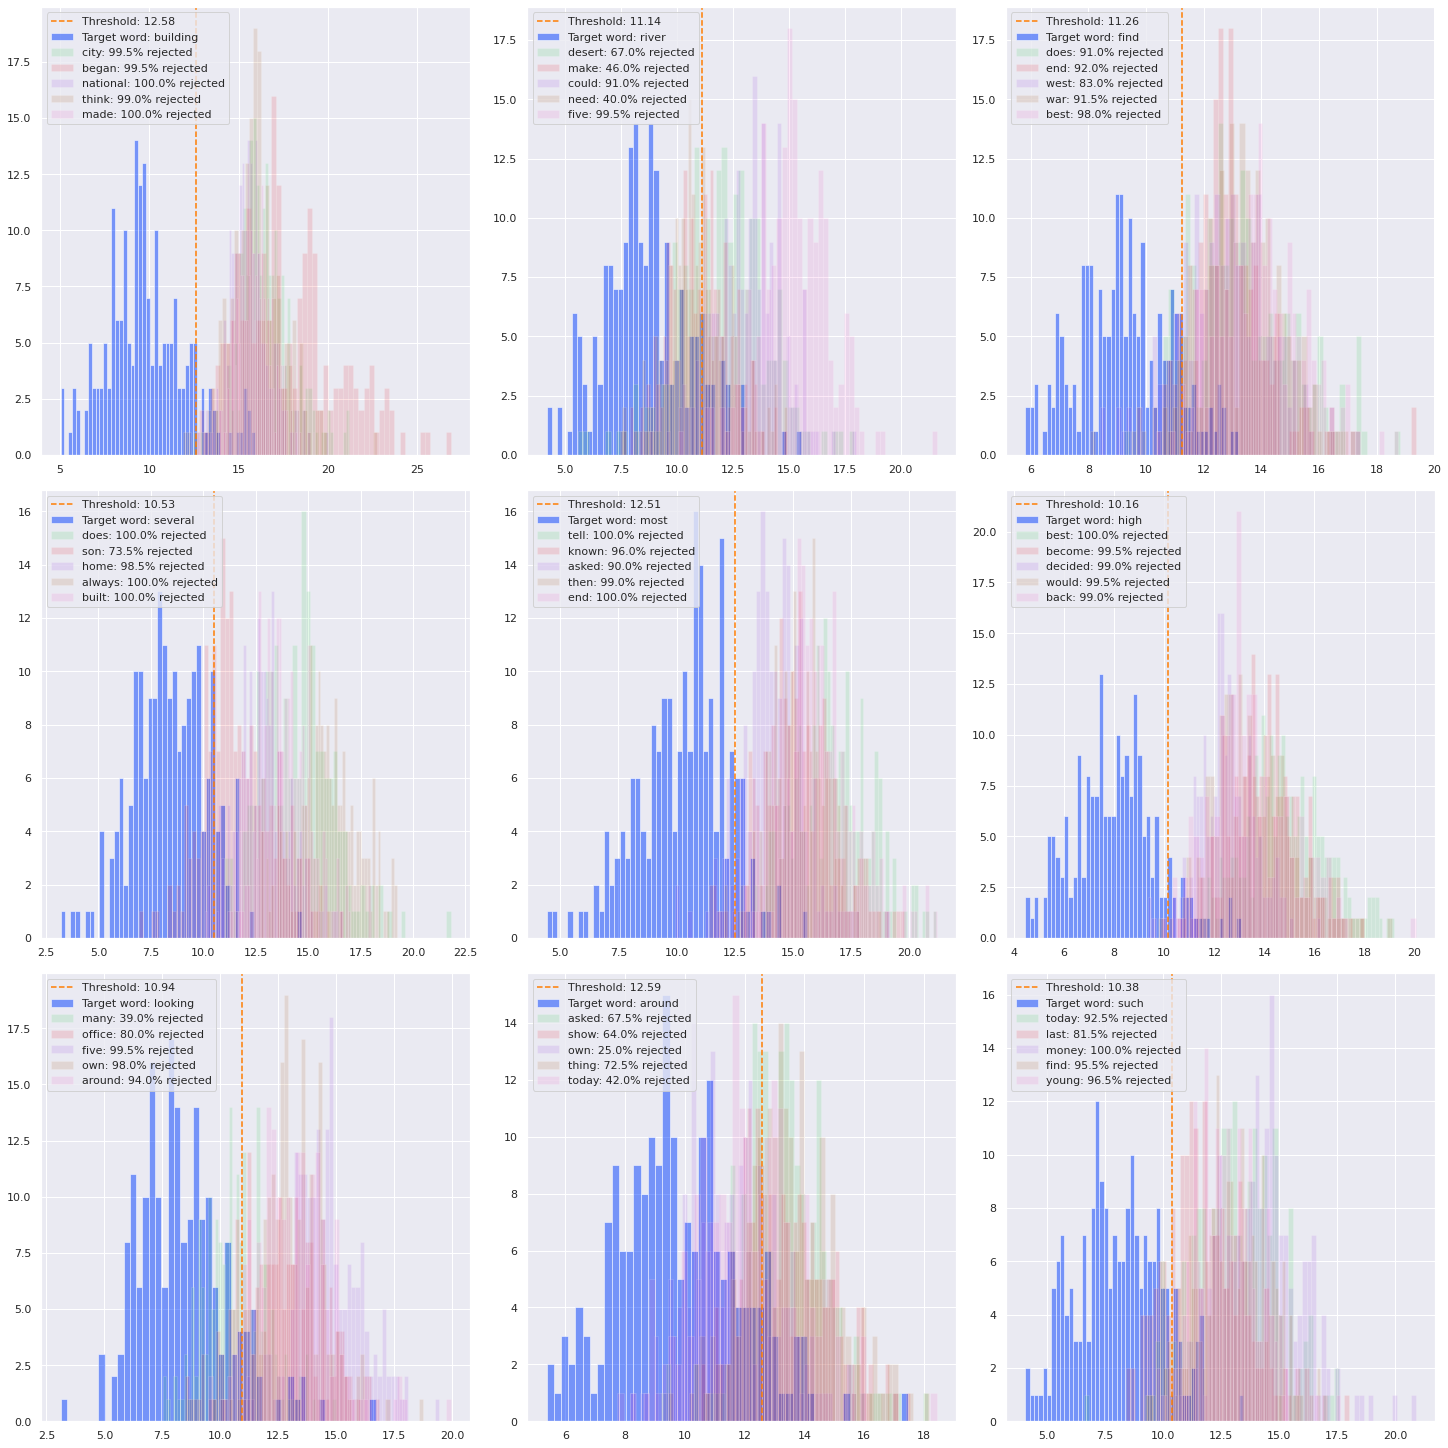

In [87]:
NUM_SAMPLES=200
THRESH = 0.90
NON_TARGET_WORDS = 5

NUM_WORDS =len(candidate_targets)
nrows,ncols = 3,3
#fig,axes= plt.subplots(nrows=nrows,ncols=ncols, gridspec_kw = {'wspace':0, 'hspace':0})
fig,axes= plt.subplots(nrows=nrows,ncols=ncols, constrained_layout=True)
assert nrows * ncols == NUM_WORDS

for ix,candidate_target in enumerate(candidate_targets):
    row = ix // nrows
    col = ix % ncols
    ax = axes[row][col]
    
    candidate_word = candidate_target.split("/")[-2]
    print(candidate_word)
    candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
    samples = np.random.choice(candidates, NUM_SAMPLES + 1, replace=False)
    samples = [w for w in samples if w != candidate_target][:NUM_SAMPLES]

    target_embedding = to_embedding(candidate_target)
    distances = np.linalg.norm(to_embeddings_vectorized(samples) - target_embedding, axis=1)
    
    threshold = np.quantile(distances, THRESH)
    
    non_target_words = np.random.choice(other_words, NON_TARGET_WORDS + 1, replace=False)
    non_target_words = [w for w in non_target_words if w != candidate_word][:NON_TARGET_WORDS]
    
    # target distance distribution
    ax.hist(distances, bins=50, alpha=0.5, label=f"Target word: {candidate_word}", color=sns.color_palette("bright")[0]);
    # target threshold
    ax.axvline(x=threshold, label=f"Threshold: {threshold:.2f}", linestyle="--", color=sns.color_palette("bright")[1])
    
    for jx, w in enumerate(non_target_words):
        non_target_candidates = glob.glob(f"{data_dir}{w}/*.wav")
        non_target_samples = np.random.choice(non_target_candidates, NUM_SAMPLES, replace=False)
        non_target_distances = np.linalg.norm(to_embeddings_vectorized(non_target_samples) - target_embedding, axis=1)
        
        correct_rejected_pct = (non_target_distances[non_target_distances > threshold].shape[0] / NUM_SAMPLES) * 100
        
        ax.hist(non_target_distances, bins=50, alpha=0.125, label=f"{w}: {correct_rejected_pct:.1f}% rejected", color=sns.color_palette("bright")[jx + 2]);        
   
    ax.legend(loc='upper left');

fig.set_size_inches(20,20);

# transfer learning experiments 

In [269]:
data_dir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/"
os.chdir("/home/mark/tinyspeech_harvard/train_100_augment/")
with open("wordlist.txt", "r") as fh:
    commands = fh.read().splitlines()
with open("files.txt", "r") as fh:
    files = fh.read().splitlines()    
    
ten_pct = int(0.1 * len(files))
train_split = ten_pct * 8 
val_split = train_split + ten_pct

train_files = files[:train_split]
val_files = files[train_split:val_split]
test_files = files[val_split:]

print(len(train_files), len(val_files), len(test_files))    
model_settings = input_data.prepare_model_settings(
        label_count=100,
        sample_rate=16000,
        clip_duration_ms=1000,
        window_size_ms=30,
        window_stride_ms=20,
        feature_bin_count=40,
        preprocess="micro",
    )
bg_datadir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/_background_noise_/"

a = input_data.AudioDataset(model_settings, commands, bg_datadir, [], unknown_percentage=0)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = a.init(AUTOTUNE, train_files, is_training=True)
val_ds = a.init(AUTOTUNE, val_files, is_training=False)
test_ds = a.init(AUTOTUNE, test_files, is_training=False)
batch_size = 64
train_ds = train_ds.shuffle(buffer_size=4000).batch(batch_size)
val_ds = val_ds.batch(batch_size)

160000 20000 20000


In [270]:
model = tf.keras.models.load_model("./hundredword_resnet_2k_selu.48-0.87")

#penultimate = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer("dense_21").output)

In [271]:
test_audio = []
test_labels = []

for ix,(audio, label) in enumerate(test_ds):
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())
    if ix % 6000 == 0:
        print(ix)
    #if ix > 8000:
    #    break

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

0
6000
12000
18000
Test set accuracy: 87%


In [272]:
other_words = [w for w in os.listdir(data_dir) if w != "_background_noise_" and w not in commands]
other_words.sort()
print(len(other_words))
assert(len(set(other_words).intersection(commands))==0)

165


In [273]:
" ".join(commands)

'night only say take blue how ever mind morning family than please nothing next different up went good main station little might right hand eyes film black use book air never district know gold already girl party yes better some game through way born those them three saw four heard one king father men something boy each school park during go things first seen road again second should number love time off red done now thought read told which played company old like world answered been music year fire found seven away everything here more town put both who often'

In [274]:
" " .join(other_words)

'about after album alchemist also always another anything appeared area around asked back based became because become before began being best between building built called children city college continued could county day days decided desert does down early earth east eight end englishman even every everyone few find five friend get give going great green group heart help high home house however idea include into just knew known language large last later left life light live local located long look looked looking lot made make man many matter mean money most much must name named national near need new nine north office once other over own part people place play playing point public really river same see served set several sheep show since six small son sound south state still street such sun system team tell then these thing think times today took under united university used very want wanted war water well west when where will wind without woman work would written years young'

In [275]:
np.random.choice(other_words, 5, replace=False)

array(['street', 'idea', 'lot', 'being', 'before'], dtype='<U10')

In [276]:
fiveword_xfer = ['street', 'idea', 'lot', 'being', 'before']

In [277]:
for w in fiveword_xfer:
    print(w in commands)

False
False
False
False
False


In [278]:
for w in fiveword_xfer:
    wavs = glob.glob(data_dir + w + "/*.wav")
    print(len(wavs))

3220
3069
3166
4209
8583


In [279]:
mini_dataset = {}
mini_val = {}

N_UTTERANCES = 20

for w in fiveword_xfer:
    wavs = glob.glob(data_dir + w + "/*.wav")
    selected = np.random.choice(wavs, 400, replace=False)
    
    mini_dataset[w] = selected[:N_UTTERANCES]
    mini_val[w] = selected[N_UTTERANCES:]

In [ ]:
model.summary()

In [303]:
# https://github.com/tensorflow/tfjs-models/blob/master/speech-commands/training/browser-fft/training_custom_audio_model_in_python.ipynb
#xfer = tf.keras.Sequential(name="TransferLearnedModel")
#for layer in model.layers[:-1]:
#    xfer.add(layer)
#xfer = tf.keras.models.clone_model(model)
#xfer.layers.pop()
#xfer.add(tf.keras.layers.Dense(units=5, activation="softmax"))   

# Freeze all but the last layer of the model. The last layer will be fine-tuned
# during transfer learning.
#for layer in xfer.layers[:-1]:
#    xfer.trainable = False

xfer = tf.keras.models.Model(name="TransferLearnedModel", inputs=model.inputs, outputs=model.get_layer(name="dense_21").output)
xfer.trainable = False

# dont use softmax here, since losses are from_logits
xfer = tf.keras.models.Sequential([xfer, tf.keras.layers.Dense(units=6)]) # 5 words + silence
    
xfer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [289]:
train_files = [f for d in mini_dataset.values() for f in d]
len(train_files)

100

In [290]:
val_files = [f for d in mini_val.values() for f in d]
len(val_files)

1900

In [293]:
np.random.shuffle(train_files)

In [295]:
train_files[:5]

['/home/mark/tinyspeech_harvard/frequent_words/en/clips/street/common_voice_en_549829.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/lot/common_voice_en_598232.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/being/common_voice_en_19717062.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/idea/common_voice_en_17269414.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/being/common_voice_en_589138.wav']

In [305]:
model_settings = input_data.prepare_model_settings(
        label_count=100,
        sample_rate=16000,
        clip_duration_ms=1000,
        window_size_ms=30,
        window_stride_ms=20,
        feature_bin_count=40,
        preprocess="micro",
    )
bg_datadir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/_background_noise_/"

a = input_data.AudioDataset(model_settings, fiveword_xfer, bg_datadir, unknown_words=[], unknown_percentage=0)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = a.init(AUTOTUNE, train_files, is_training=True)
val_ds = a.init(AUTOTUNE, val_files, is_training=False)
#test_ds = a.init(AUTOTUNE, test_files, is_training=False)
batch_size = 64
train_ds = train_ds.shuffle(buffer_size=4000).batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [306]:
a.commands

<tf.Tensor: shape=(6,), dtype=string, numpy=
array([b'_silence_', b'street', b'idea', b'lot', b'being', b'before'],
      dtype=object)>

In [307]:
EPOCHS = 100
history = xfer.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    #callbacks=[model_checkpoint_callback]
    # callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=4),
    #            tf.keras.callbacks.LearningRateScheduler(scheduler)],
)

Epoch 1/100
2/2 [==============================] - 1s 491ms/step - loss: 2.3147 - accuracy: 0.1400 - val_loss: 2.3448 - val_accuracy: 0.1153
Epoch 2/100
2/2 [==============================] - 0s 212ms/step - loss: 2.1056 - accuracy: 0.2100 - val_loss: 2.2087 - val_accuracy: 0.1384
Epoch 3/100
2/2 [==============================] - 0s 213ms/step - loss: 1.9715 - accuracy: 0.2900 - val_loss: 2.0780 - val_accuracy: 0.1705
Epoch 4/100
2/2 [==============================] - 0s 218ms/step - loss: 1.8832 - accuracy: 0.2900 - val_loss: 1.9515 - val_accuracy: 0.2116
Epoch 5/100
2/2 [==============================] - 0s 212ms/step - loss: 1.7800 - accuracy: 0.2700 - val_loss: 1.8307 - val_accuracy: 0.2579
Epoch 6/100
2/2 [==============================] - 0s 212ms/step - loss: 1.6745 - accuracy: 0.3700 - val_loss: 1.7141 - val_accuracy: 0.3079
Epoch 7/100
2/2 [==============================] - 0s 215ms/step - loss: 1.5576 - accuracy: 0.4100 - val_loss: 1.6027 - val_accuracy: 0.3689
Epoch 8/100
2

In [308]:
xfer.save("xfer_5word")

INFO:tensorflow:Assets written to: xfer_5word/assets


groundtruth idea /home/mark/tinyspeech_harvard/frequent_words/en/clips/idea/common_voice_en_18708296.wav
prediction idea


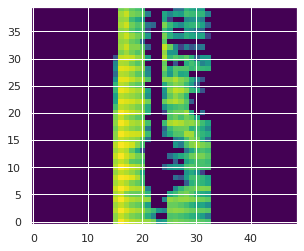

In [348]:
word = np.random.choice(fiveword_xfer)

f = np.random.choice(glob.glob(data_dir + word + "/*.wav"))

print("groundtruth", word, f)
spec = a.file2spec(f)

plt.imshow(spec.numpy().T, origin="lower", cmap="viridis");

pred = xfer.predict(spec.numpy().reshape(1,49,40,1))
p = np.argmax(pred)
print("prediction", a.commands[p].numpy().decode('utf8'))

_,wav = wavfile.read(f)
ipd.Audio(wav,rate=16000, autoplay=True)

In [349]:
len(train_files)

100

In [350]:
fiveword_xfer

['street', 'idea', 'lot', 'being', 'before']

In [351]:
len(val_files)

1900